# **Gesture Recognition for Human-Computer Interaction**

## **Table of Contents**

1. Introduction
2. Data Preparation & Cleaning
3. Model Training
4. Hyper-parameter tuning
5. WandB Reoirt
6. Transfer Learning
7. Challenge and Resolutions
8. Conclusion
9. Reference

## **1. Introduction**

### **Contributors**
*   Ya Chu (Rhetta) Hsu
*   Yi-Cheng Chung
*   Yu-Chin (Alyssa)
*   Shuo Ming (Chris) Kuo

### **Motivation**

Neural network technologies can be beneficial in finding innovative solutions to real-world business challenges, especially those involving complex data. Gesture recognition for human-computer interaction entails the use of algorithms and sensors to interpret human gestures as commands. This technology enables users to interact with computers or devices without physical touch, utilizing movements of the hands, fingers, or even the entire body. It has been applied in various fields such as gaming, virtual reality, robotics, and assistive technology for the disabled, thereby enhancing the intuitiveness and accessibility of device control. Neural networks in Gesture Recognition for Human-Computer Interaction can further enhance technology and propel it to a higher level.



### **Problem Statement**

The technology of Gesture Recognition for Human-Computer Interaction has not yet matured, so there are not many successful, well-known, and globally used products. In our project, we aim to utilize neural networks and analyze videos and pictures to predict the accuracy of over 20 different gestures, each comprising 47 videos as inputs. The output will be the gesture classification, which we will use to assess accuracy, in an effort to enhance Gesture Recognition for Human-Computer Interaction and advance the technology.

### **Dataset**

This dataset (ChaLearn) contains a wide range of movements recorded using Kinect cameras, which includes 50,000 samples stored as AVI files. These samples consist of videos showing color and depth, with each frame being 240 x 320 pixels. The data comes from recordings made by 20 different users and is organized into 500 batches, each containing 100 movements. Within these groups, movements are grouped into 47 sequences, each sequence having 1 to 5 movements from various small movement sets, totaling over 30 different sets.
Additionally, the dataset has two main parts.First, the devel-1-480 archive has labeled samples used to build and test the model. Second, verify that the 1-20 archives have no labels, used to check how well the predictions match the real data.

## **2. Data Preparation and Cleaning**

### **Input Data from folder**

**Currently, our objective is to reduce the dataset size by downsampling. As a result, we're dividing the videos from the whole folders to only first 10 folders and saving them into new directories.**

In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd

def change_value(df,index):
  # df has two columns: 'Name' and 'Label'
  for idx in range(len(df)):
    if idx < len(df)/2:
        df.iloc[idx,0] =  df.iloc[idx,0].replace('devel','')
        df.iloc[idx,0] =  df.iloc[idx,0].split('_')[0] + '_M_' + df.iloc[idx,0].split('_')[1] + '.avi'
    else:
        df.iloc[idx,0] =  df.iloc[idx,0].replace('devel','')
        df.iloc[idx,0] =  df.iloc[idx,0].split('_')[0] + '_K_' + df.iloc[idx,0].split('_')[1] + '.avi'
  df['Label'] = '_' + df['Label'].astype('string').str.strip().replace(' ','')
  df['Label'] = str(index) + df['Label']
  return df

def copy_file(index,df,new_folder,path_folder):
  # Get full video path
  if index < 10:
    video_path = [os.path.join(path_folder+'devel0'+str(index)+'/', f) for f in os.listdir(path_folder+'devel0'+str(index)+'/') if f.endswith(".avi")]
  else:
    video_path = [os.path.join(path_folder+'devel'+str(index)+'/', f) for f in os.listdir(path_folder+'devel'+str(index)+'/') if f.endswith(".avi")]
  # Loop through df to identify video need to be copied
  for name in df['Name']:
    # search_pattern set [3:] when two-digit, set [4:] when three-digit
    search_pattern = name[3:]
    matches = [path for path in video_path if path.endswith(search_pattern)]
    old_path = ' '.join([str(elem) for elem in matches])
    new_path = new_folder + name
    shutil.copy(old_path, new_path)

In [ ]:
# Create df_train and df_test that contains filename and labelname (file: folder_num + M + video_num + '.avi', label: folder_num + label)
path_folder = '/content/gdrive/MyDrive/BA865/data/devel01-40/'
train_folder = '/content/gdrive/MyDrive/BA865/data/train_data/'
test_folder = '/content/gdrive/MyDrive/BA865/data/test_data/'

# Check if history train and test csv exists
if os.path.exists('/content/gdrive/MyDrive/BA865/data/test_data/test.csv'):
  df_train_all = pd.read_csv(train_folder +'train.csv')
  df_test_all = pd.read_csv(test_folder +'test.csv')
else:
  df_train_all = pd.DataFrame(columns=['Name','Label'])
  df_test_all = pd.DataFrame(columns=['Name','Label'])

# Loop through the directory: i must put the folder name
for index in range(0,40):
  if index < 10:
    df_train = pd.read_csv(path_folder + 'devel0' + str(index) + '/devel0' + str(index) + '_train.csv',header=None)
    df_test = pd.read_csv(path_folder + 'devel0' + str(index) + '/devel0' + str(index) +'_test.csv',header=None)
  elif index > 9:
    df_train = pd.read_csv(path_folder + 'devel' +str(index) + '/devel' + str(index) + '_train.csv',header=None)
    df_test = pd.read_csv(path_folder + 'devel' + str(index) + '/devel' + str(index) +'_test.csv',header=None)

  # Training data
  df_train = df_train.rename({0:'Name',1:'Label'},axis=1)
  df_train = pd.concat([df_train,df_train],axis=0).reset_index(drop=True)

  # 1. Change Name and Label (first M.avi then K.avi)
  df_train = change_value(df_train,index)
  df_train_all = pd.concat([df_train_all,df_train],axis=0).reset_index(drop=True)
  # 2. Move video to new folder
  copy_file(index,df_train,train_folder)


  # Testing data
  df_test['Value_count'] = df_test[1].apply(lambda x: len(x.split()))
  df_test = df_test[df_test['Value_count'] == 1]
  df_test = df_test.drop('Value_count',axis=1)
  df_test = df_test.rename({0:'Name',1:'Label'},axis=1)
  df_test = pd.concat([df_test,df_test],axis=0).reset_index(drop=True)

  # 1. Change Name and Label (first M.avi then K.avi)
  df_test = change_value(df_test,index)
  df_test_all = pd.concat([df_test_all,df_test],axis=0).reset_index(drop=True)
  # 2. Move video to new folder
  copy_file(index,df_test,test_folder)
print('Train data moved from file')
print('Test data moved from file')

Train data moved from file
Test data moved from file


In [ ]:
# Save csv to drive
df_train_all.to_csv('/content/gdrive/MyDrive/BA865/data/train_data/train.csv')
df_test_all.to_csv('/content/gdrive/MyDrive/BA865/data/test_data/test.csv')
print('CSV files saved to drive')

CSV files saved to drive


### **Generate Frame Data (Model input data)**

**Afterward, we split the video data into image frames, capturing frames at intervals of 0.05 seconds.**

In [ ]:
# Import necessary libraries
import os
import cv2
from natsort import natsorted

def create_frame(video_folder_path,frame_folder_path):
  sorted_folder_path = natsorted(os.listdir(video_folder_path))
  total_frame = 0 #just for checking
  for filename in sorted_folder_path:
    # Get the video original folder name
    file_name = str(os.path.basename(filename)).split('_')[0]
    # Set the high, low bounds for looping
    if int(file_name) > 0 and int(file_name) < 11:
      video_path = os.path.join(video_folder_path, filename)
      video_name = os.path.basename(video_path).replace('.avi','')

      cap = cv2.VideoCapture(video_path)
      count = 0
      while True:
        # count*50 refer to 0.05 sec per frame
        cap.set(cv2.CAP_PROP_POS_MSEC,(count*50))
        ret, frame = cap.read()
        if not ret:
          break
        frame_path = os.path.join(frame_folder_path, f'{video_name}-{count+1}.jpg')
        cv2.imwrite(frame_path, frame)
        count += 1

      # Release the video capture object
      cap.release()
      total_frame += count
    elif int(file_name) > 10:
      break

  print(f'Total frame count: {total_frame}')

In [ ]:
# Create frame from video - Train
train_folder = '/content/gdrive/MyDrive/BA865/data/train_data/'
train_frame = '/content/gdrive/MyDrive/BA865/data/train_frame/'

create_frame(train_folder,train_frame)

# Create frame from video - Test
test_folder = '/content/gdrive/MyDrive/BA865/data/test_data/'
test_frame = '/content/gdrive/MyDrive/BA865/data/test_frame/'

create_frame(test_folder,test_frame)

### **Load Data to loader**

**Finally, we begin loading the image data and associating each image with its corresponding label, followed by label encoding.**

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from natsort import natsorted
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import necessary files
train_label_path = '/content/gdrive/MyDrive/BA865/data/train.csv'
test_label_path = '/content/gdrive/MyDrive/BA865/data/test.csv'
train_folder_path = '/content/gdrive/MyDrive/BA865/data/train_frame_final/'
test_folder_path = '/content/gdrive/MyDrive/BA865/data/test_frame_final/'

df_train = pd.read_csv(train_label_path)
df_test = pd.read_csv(test_label_path)

def create_list(path_folder):
  data = []
  for image_name in natsorted(os.listdir(path_folder)):
    image_path = os.path.join(path_folder, image_name)
    # Create dictonary for dataframe input
    data.append({
        'Path': image_path,
        'Image_name': image_name,
        'Video_name': image_name.split('-')[0] +'.avi',
    })
  return data

In [ ]:
# Create df_train_final
df_train_final = pd.DataFrame(create_list(train_folder_path))
# Encode the labels
label = LabelEncoder().fit_transform(df_train['Label'])
df_train['Label_encode'] = label
# Merge dataframe with label
df_train_final = pd.merge(df_train_final, df_train[['Name','Label','Label_encode']], left_on='Video_name', right_on = 'Name')
df_train_final = df_train_final[['Path','Label','Label_encode']]

# Create df_test_final
df_test_final = pd.DataFrame(create_list(test_folder_path))
# Merge frame dataframe with label dataframe
df_test_final = pd.merge(df_test_final, df_test[['Name','Label']], left_on='Video_name', right_on = 'Name')
df_test_final = df_test_final[['Path','Label']]
df_test_final = pd.merge(df_test_final,df_train[['Label','Label_encode']],on='Label',how='left')
df_test_final = df_test_final.drop_duplicates()

# Finalize dataset
df_train_final = df_train_final[['Path','Label_encode']]
df_test_final = df_test_final[['Path','Label_encode']]
df_train_final['Label_encode'] = df_train_final['Label_encode'].astype(str)
df_test_final['Label_encode'] = df_test_final['Label_encode'].astype(str)

<ipython-input-3-55828464b670>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_final['Label_encode'] = df_train_final['Label_encode'].astype(str)


### **Data Augmentation**

**We used ImageDataGenerator to create more variety of training data, including methods like rotating, shearing, zooming and flipping.**

In [ ]:
# Create train datagen
train_datagen = ImageDataGenerator(
          rescale=1./255,
          rotation_range=45,
          shear_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')
# Create test datagen
test_datagen = ImageDataGenerator(rescale=1./255)

# Create train generator - not using WandB
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train_final,
    directory=None,
    x_col='Path',
    y_col='Label_encode',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
)

# Create test generator - not using WandB
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test_final,
    directory=None,
    x_col='Path',
    y_col='Label_encode',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
)

# Get number of classes: for classification
num_classes = df_train_final['Label_encode'].nunique()

Found 4724 validated image filenames belonging to 20 classes.
Found 5764 validated image filenames belonging to 20 classes.


## **3. Model building and training**

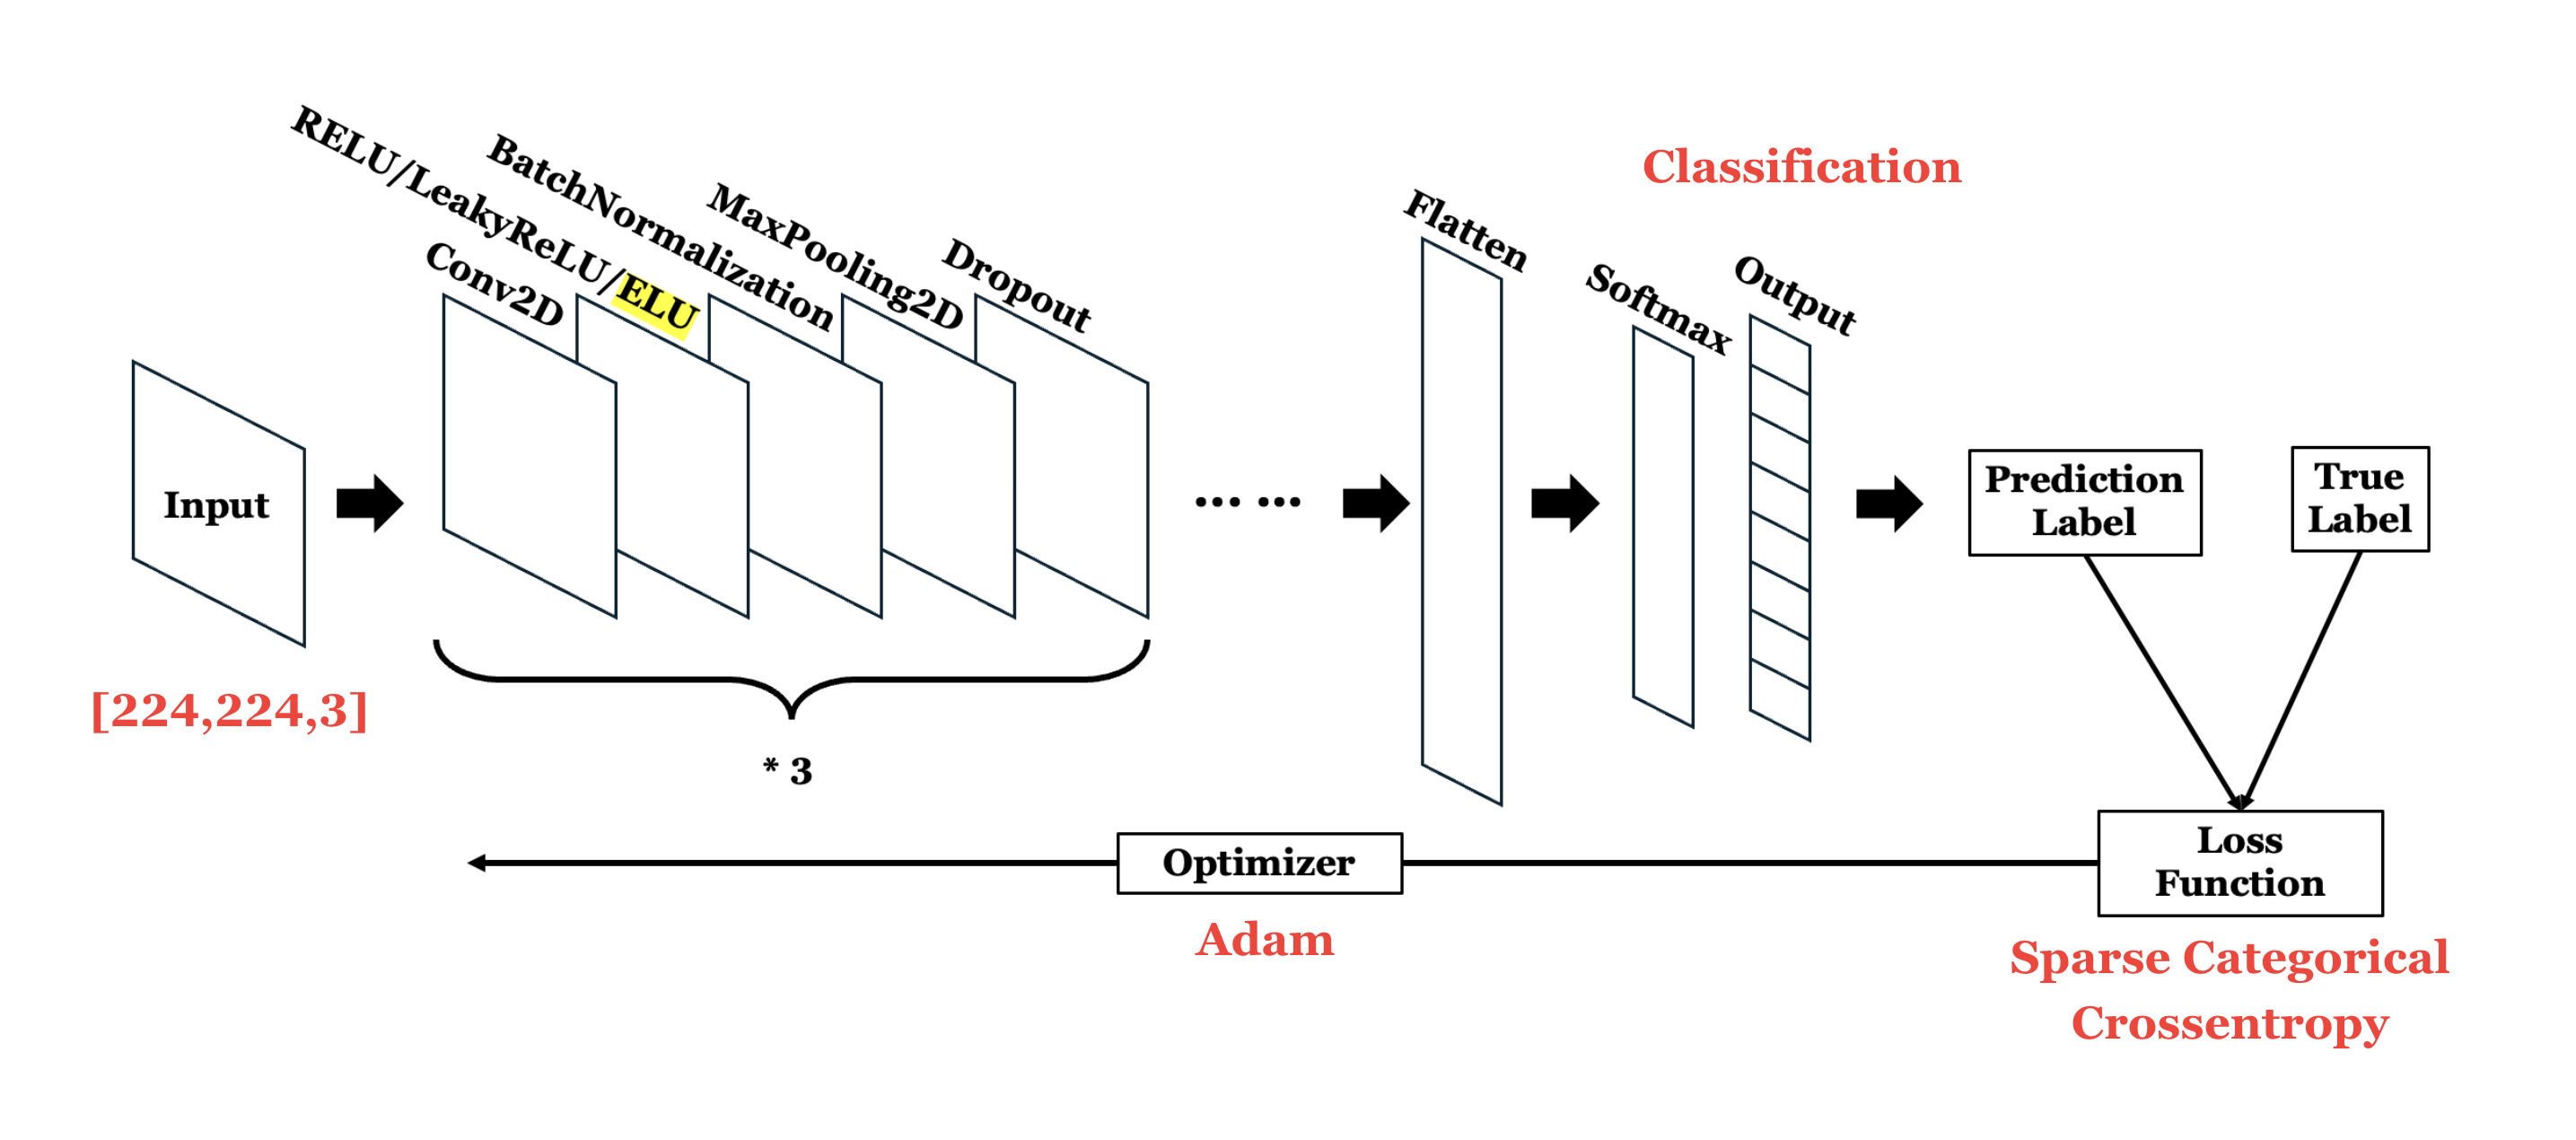

**At this stage, we're determining the most effective activation function. We've experimented with ReLU, LeakyReLU, and ELU simultaneously.**

In [ ]:
# Import necessary libraries
import time
import keras
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization,GlobalAveragePooling2D
from keras.optimizers import SGD, Adam

Epoch 1/10
147/147 [==============================] - 59s 388ms/step - loss: 18.0439 - accuracy: 0.4819
Epoch 2/10
147/147 [==============================] - 58s 395ms/step - loss: 13.0673 - accuracy: 0.6571
Epoch 3/10
147/147 [==============================] - 58s 391ms/step - loss: 9.5537 - accuracy: 0.7114
Epoch 4/10
147/147 [==============================] - 58s 393ms/step - loss: 7.4583 - accuracy: 0.7511
Epoch 5/10
147/147 [==============================] - 58s 391ms/step - loss: 6.6363 - accuracy: 0.7671
Epoch 6/10
147/147 [==============================] - 57s 390ms/step - loss: 5.1062 - accuracy: 0.8009
Epoch 7/10
147/147 [==============================] - 57s 390ms/step - loss: 4.5034 - accuracy: 0.8018
Epoch 8/10
147/147 [==============================] - 58s 396ms/step - loss: 4.4541 - accuracy: 0.7986
Epoch 9/10
147/147 [==============================] - 58s 391ms/step - loss: 2.9288 - accuracy: 0.8321
Epoch 10/10
147/147 [==============================] - 58s 392ms/step -

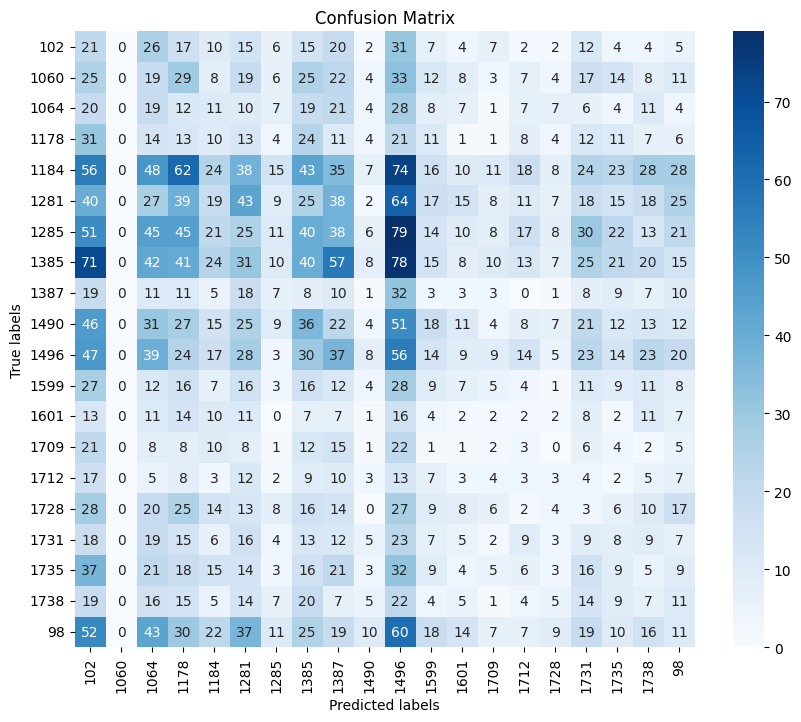

In [ ]:
# Model with ReLU
from keras.layers import ReLU

def main():
  # Build the model
  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(224,224,3)))
  model.add(ReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, kernel_size=3, padding='same'))
  model.add(ReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, kernel_size=5, padding='same'))
  model.add(ReLU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(num_classes,activation='softmax'))

  # Complie the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  start_time = time.time() # Start time

  # Fit the model
  model.fit(train_generator,steps_per_epoch=train_generator.samples // train_generator.batch_size,epochs=10)

  end_time = time.time() # End time
  duration = end_time - start_time # Duration
  print(f"Training the model took {duration:.2f} seconds.")

  # Evaluate the model
  start_time = time.time() # Start time
  test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
  print("Test Accuracy:", test_acc * 100 , "%")
  print('Test Loss:',test_loss)
  end_time = time.time() # End time
  duration = end_time - start_time # Duration
  print(f"Evaluating the model took {duration:.2f} seconds.")

  print("========================================")
  y_pred = np.argmax(model.predict(test_generator), axis=1)
  y_true = test_generator.classes
  f1 = f1_score(y_true, y_pred, average='weighted')
  cm = confusion_matrix(y_true, y_pred)
  print(f"F1 Score: {f1}")
  # print(f"Confusion Matrix: {cm}")
  print("========================================")
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

main()

Epoch 1/10
147/147 [==============================] - 59s 390ms/step - loss: 17.6842 - accuracy: 0.5040
Epoch 2/10
147/147 [==============================] - 58s 392ms/step - loss: 11.8839 - accuracy: 0.6579
Epoch 3/10
147/147 [==============================] - 58s 392ms/step - loss: 9.0757 - accuracy: 0.7091
Epoch 4/10
147/147 [==============================] - 58s 391ms/step - loss: 8.3585 - accuracy: 0.7381
Epoch 5/10
147/147 [==============================] - 58s 394ms/step - loss: 6.6789 - accuracy: 0.7549
Epoch 6/10
147/147 [==============================] - 58s 393ms/step - loss: 5.6487 - accuracy: 0.7852
Epoch 7/10
147/147 [==============================] - 57s 388ms/step - loss: 4.5099 - accuracy: 0.8016
Epoch 8/10
147/147 [==============================] - 58s 395ms/step - loss: 3.9883 - accuracy: 0.8073
Epoch 9/10
147/147 [==============================] - 57s 390ms/step - loss: 3.5348 - accuracy: 0.8135
Epoch 10/10
147/147 [==============================] - 59s 399ms/step -

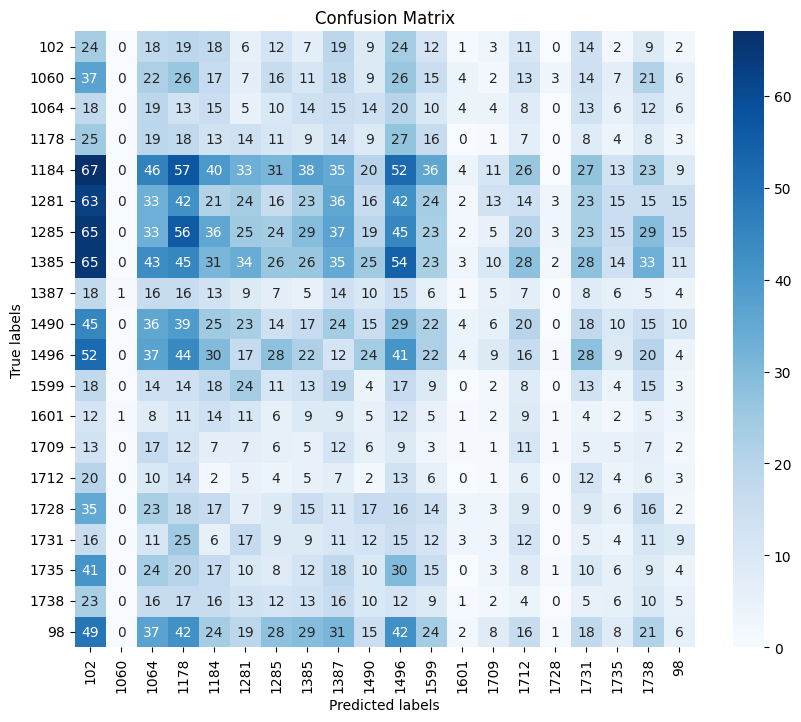

In [ ]:
# Model with LeakyReLU
from keras.layers import LeakyReLU

def main():
  # Build the model
  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(224,224,3)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, kernel_size=3, padding='same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, kernel_size=5, padding='same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2))
  model.add(Dropout(0.2))


  model.add(Flatten())
  model.add(Dense(num_classes,activation='softmax'))

  # Compile the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  start_time = time.time() # Start time

  # Fit the model
  model.fit(train_generator,steps_per_epoch=train_generator.samples // train_generator.batch_size,epochs=10)

  end_time = time.time() # End time
  duration = end_time - start_time # Duration
  print(f"Training the model took {duration:.2f} seconds.")

  # Evaluate the model
  start_time = time.time() # Start time
  test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
  print("Test Accuracy:", test_acc * 100 , "%")
  print('Test Loss:',test_loss)
  end_time = time.time() # End time
  duration = end_time - start_time # Duration
  print(f"Evaluating the model took {duration:.2f} seconds.")

  print("========================================")
  y_pred = np.argmax(model.predict(test_generator), axis=1)
  y_true = test_generator.classes
  f1 = f1_score(y_true, y_pred, average='weighted')
  cm = confusion_matrix(y_true, y_pred)
  print(f"F1 Score: {f1}")
  print("========================================")
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

main()

Epoch 1/10
147/147 [==============================] - 62s 395ms/step - loss: 17.5921 - accuracy: 0.4770
Epoch 2/10
147/147 [==============================] - 58s 393ms/step - loss: 14.3528 - accuracy: 0.6104
Epoch 3/10
147/147 [==============================] - 58s 391ms/step - loss: 10.3765 - accuracy: 0.6848
Epoch 4/10
147/147 [==============================] - 58s 396ms/step - loss: 9.4045 - accuracy: 0.7104
Epoch 5/10
147/147 [==============================] - 58s 394ms/step - loss: 7.1777 - accuracy: 0.7519
Epoch 6/10
147/147 [==============================] - 59s 397ms/step - loss: 5.9072 - accuracy: 0.7728
Epoch 7/10
147/147 [==============================] - 58s 397ms/step - loss: 4.3804 - accuracy: 0.7997
Epoch 8/10
147/147 [==============================] - 58s 395ms/step - loss: 3.9415 - accuracy: 0.8148
Epoch 9/10
147/147 [==============================] - 58s 392ms/step - loss: 3.5428 - accuracy: 0.8182
Epoch 10/10
147/147 [==============================] - 57s 390ms/step 

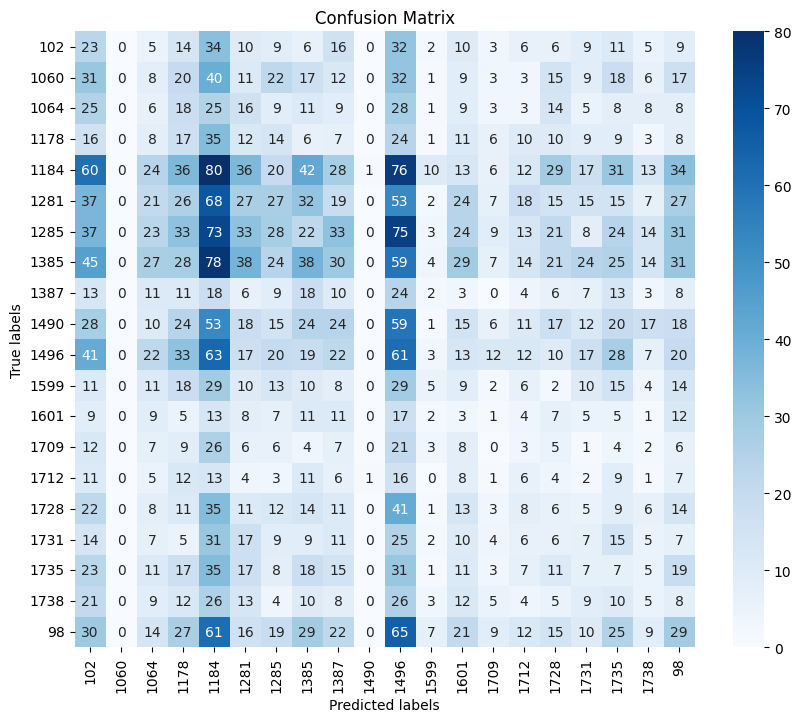

In [ ]:
# Model with ELU
from keras.layers import ELU

def main():
  # Build the model
  model = Sequential()

  model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(224,224,3)))
  model.add(ELU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, kernel_size=3, padding='same'))
  model.add(ELU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, kernel_size=5, padding='same'))
  model.add(ELU())
  model.add(BatchNormalization())
  model.add(MaxPooling2D(2))
  model.add(Dropout(0.2))


  model.add(Flatten())
  model.add(Dense(num_classes,activation='softmax'))

  # Compile the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  start_time = time.time() # Start time

  # Fit the model
  model.fit(train_generator,steps_per_epoch=train_generator.samples // train_generator.batch_size,epochs=10)

  end_time = time.time() # End time
  duration = end_time - start_time # Duration
  print(f"Training the model took {duration:.2f} seconds.")

  # Evaluate the model
  start_time = time.time() # Start time
  test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
  print("Test Accuracy:", test_acc * 100 , "%")
  print('Test Loss:',test_loss)
  end_time = time.time() # End time
  duration = end_time - start_time # Duration
  print(f"Evaluating the model took {duration:.2f} seconds.")

  print("========================================")
  y_pred = np.argmax(model.predict(test_generator), axis=1)
  y_true = test_generator.classes
  f1 = f1_score(y_true, y_pred, average='weighted')
  cm = confusion_matrix(y_true, y_pred)
  print(f"F1 Score: {f1}")
  print("========================================")
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

main()


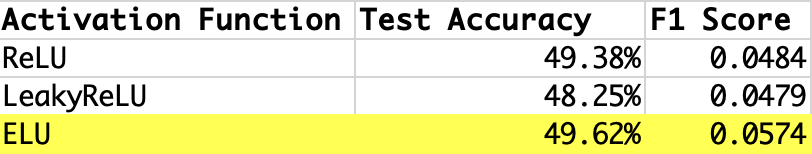


**Ultimately, we've observed that ELU yields the best performance. Moving forward, we'll adopt ELU as our activation function for the subsequent steps.**

## **4. Hyper-parameter tuning**

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
# Import Necessary Libraries
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score
import wandb
from wandb.keras import WandbCallback

# Log in to WandB
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Define Callback class
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs=None):
        x, y_true = self.test_data
        y_pred = np.argmax(self.model.predict(x), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        wandb.log({"F1 Score": f1, "Confusion Matrix": wandb.plot.confusion_matrix(probs=None, y_true=y_true, preds=y_pred)})

def main():
    # Initialize WandB
    wandb.init()
    # Initialize config
    config = wandb.config

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(224,224,3)))
    model.add(ELU(alpha=1.0))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    model.add(Dropout(config.drop_out))

    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(ELU(alpha=1.0))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    model.add(Dropout(config.drop_out))

    model.add(Conv2D(128, kernel_size=5, padding='same'))
    model.add(ELU(alpha=1.0))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    model.add(Dropout(config.drop_out))

    model.add(Flatten())
    model.add(Dense(config.num_classes, activation='softmax'))

    # Compile the model with the specified learning rate
    optimizer = Adam(learning_rate=config.learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time() # Start time

    model.fit(train_generator, epochs=10, callbacks=[WandbCallback(), MetricsCallback((test_generator, test_generator.classes))])

    end_time = time.time() # End time
    duration = end_time - start_time # Duration
    print(f"Training the model took {duration:.2f} seconds.")

    # Evaluate the model
    start_time = time.time() # Start time
    test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    wandb.log({"Test Accuracy": test_acc, "Test Loss": test_loss})
    print("Test Accuracy:", test_acc * 100 , "%")
    print('Test Loss:',test_loss)
    end_time = time.time() # End time
    duration = end_time - start_time # Duration
    print(f"Evaluating the model took {duration:.2f} seconds.")

# Define the sweep configuration
sweep_config = {
    'method': 'grid',
    'parameters': {
        'drop_out': {
            'values': [0.2, 0.3]
        },
        'learning_rate': {
            'values': [0.01, 0.001]
        },
        'num_classes': {
            'values': [num_classes]
        },
        'batch_size': {
            'values': [32, 64]
        }
    }
}

# Initialize sweep by passing in the config
sweep_id = wandb.sweep(sweep_config, project="BA865_Gesture_Recognition_Final")

# Start sweep job
wandb.agent(sweep_id, function=main)

# Finish sweep job
wandb.finish()

Create sweep with ID: ijqyfi3z
Sweep URL: https://wandb.ai/alyssachen/BA865_Gesture_Recognition_Final/sweeps/ijqyfi3z


wandb: Agent Starting Run: z42cwl1q with config:
wandb: 	batch_size: 32
wandb: 	drop_out: 0.2
wandb: 	learning_rate: 0.01
wandb: 	num_classes: 20
wandb: Currently logged in as: ethanch (alyssachen). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
148/148 [==============================] - 4034s 27s/step - loss: 93.6113 - accuracy: 0.5216
Epoch 2/10
148/148 [==============================] - 76s 513ms/step - loss: 10.8107 - accuracy: 0.6905
Epoch 3/10
148/148 [==============================] - 76s 511ms/step - loss: 1.0239 - accuracy: 0.7572
Epoch 4/10
148/148 [==============================] - 76s 513ms/step - loss: 0.7398 - accuracy: 0.7771
Epoch 5/10
148/148 [==============================] - 76s 512ms/step - loss: 0.6219 - accuracy: 0.7860
Epoch 6/10
148/148 [==============================] - 75s 509ms/step - loss: 0.5186 - accuracy: 0.8063
Epoch 7/10
148/148 [==============================] - 77s 520ms/step - loss: 0.5293 - accuracy: 0.8033
Epoch 8/10
148/148 [==============================] - 76s 515ms/step - loss: 0.4951 - accuracy: 0.8086
Epoch 9/10
148/148 [==============================] - 76s 511ms/step - loss: 0.4375 - accuracy: 0.8215
Epoch 10/10
148/148 [==============================] - 75s 508ms/step -

F1 Score,▁▅▇▇█▇▅▅▇▆
Test Accuracy,▁
Test Loss,▁
accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
F1 Score,0.04002
Test Accuracy,0.52135
Test Loss,2.49721
accuracy,0.80737
epoch,9


wandb: Agent Starting Run: jyh3rdm5 with config:
wandb: 	batch_size: 32
wandb: 	drop_out: 0.2
wandb: 	learning_rate: 0.001
wandb: 	num_classes: 20


Epoch 1/10
148/148 [==============================] - 77s 509ms/step - loss: 19.9460 - accuracy: 0.4600
Epoch 2/10
148/148 [==============================] - 76s 511ms/step - loss: 14.0524 - accuracy: 0.6012
Epoch 3/10
148/148 [==============================] - 76s 517ms/step - loss: 11.1072 - accuracy: 0.6723
Epoch 4/10
148/148 [==============================] - 77s 519ms/step - loss: 8.2012 - accuracy: 0.7174
Epoch 5/10
148/148 [==============================] - 76s 512ms/step - loss: 7.2493 - accuracy: 0.7534
Epoch 6/10
148/148 [==============================] - 76s 513ms/step - loss: 6.0926 - accuracy: 0.7735
Epoch 7/10
148/148 [==============================] - 76s 517ms/step - loss: 5.1451 - accuracy: 0.7811
Epoch 8/10
148/148 [==============================] - 76s 516ms/step - loss: 4.7729 - accuracy: 0.7932
Epoch 9/10
148/148 [==============================] - 76s 513ms/step - loss: 4.0189 - accuracy: 0.8004
Epoch 10/10
148/148 [==============================] - 76s 515ms/step 

F1 Score,▂▁▄▇█▇▇▇█▇
Test Accuracy,▁
Test Loss,▁
accuracy,▁▄▅▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
F1 Score,0.04228
Test Accuracy,0.49427
Test Loss,15.20911
accuracy,0.8116
epoch,9


wandb: Agent Starting Run: 1uqw27pd with config:
wandb: 	batch_size: 32
wandb: 	drop_out: 0.3
wandb: 	learning_rate: 0.01
wandb: 	num_classes: 20


Epoch 1/10
148/148 [==============================] - 77s 509ms/step - loss: 95.1914 - accuracy: 0.4970
Epoch 2/10
148/148 [==============================] - 76s 511ms/step - loss: 8.4427 - accuracy: 0.6723
Epoch 3/10
148/148 [==============================] - 76s 514ms/step - loss: 0.7670 - accuracy: 0.7439
Epoch 4/10
148/148 [==============================] - 76s 514ms/step - loss: 0.9287 - accuracy: 0.7367
Epoch 5/10
148/148 [==============================] - 75s 509ms/step - loss: 0.7657 - accuracy: 0.7674
Epoch 6/10
148/148 [==============================] - 76s 514ms/step - loss: 0.5832 - accuracy: 0.7796
Epoch 7/10
148/148 [==============================] - 76s 513ms/step - loss: 0.6150 - accuracy: 0.7824
Epoch 8/10
148/148 [==============================] - 75s 510ms/step - loss: 0.5250 - accuracy: 0.7964
Epoch 9/10
148/148 [==============================] - 75s 510ms/step - loss: 0.5663 - accuracy: 0.7938
Epoch 10/10
148/148 [==============================] - 75s 509ms/step - 

F1 Score,▁▆▅▇▇▇▇█▇▇
Test Accuracy,▁
Test Loss,▁
accuracy,▁▅▇▇▇████▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
F1 Score,0.04298
Test Accuracy,0.50625
Test Loss,2.15009
accuracy,0.76799
epoch,9


wandb: Agent Starting Run: 8wfy74ef with config:
wandb: 	batch_size: 32
wandb: 	drop_out: 0.3
wandb: 	learning_rate: 0.001
wandb: 	num_classes: 20


Epoch 1/10
148/148 [==============================] - 77s 511ms/step - loss: 18.3125 - accuracy: 0.4562
Epoch 2/10
148/148 [==============================] - 76s 517ms/step - loss: 12.5195 - accuracy: 0.6016
Epoch 3/10
148/148 [==============================] - 75s 509ms/step - loss: 10.3663 - accuracy: 0.6734
Epoch 4/10
148/148 [==============================] - 77s 518ms/step - loss: 9.0620 - accuracy: 0.6962
Epoch 5/10
148/148 [==============================] - 76s 511ms/step - loss: 7.3149 - accuracy: 0.7250
Epoch 6/10
148/148 [==============================] - 76s 512ms/step - loss: 6.1543 - accuracy: 0.7498
Epoch 7/10
148/148 [==============================] - 75s 510ms/step - loss: 5.1948 - accuracy: 0.7720
Epoch 8/10
148/148 [==============================] - 77s 520ms/step - loss: 3.8845 - accuracy: 0.7970
Epoch 9/10
148/148 [==============================] - 77s 517ms/step - loss: 3.0772 - accuracy: 0.8072
Epoch 10/10
148/148 [==============================] - 77s 517ms/step 

F1 Score,▁▁▆▆▇▆▅▆█▇
Test Accuracy,▁
Test Loss,▁
accuracy,▁▄▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▄▃▂▂▁▁▁
F1 Score,0.04282
Test Accuracy,0.43437
Test Loss,15.48591
accuracy,0.80483
epoch,9


wandb: Agent Starting Run: uiggyaiq with config:
wandb: 	batch_size: 64
wandb: 	drop_out: 0.2
wandb: 	learning_rate: 0.01
wandb: 	num_classes: 20


Epoch 1/10
148/148 [==============================] - 79s 517ms/step - loss: 100.2015 - accuracy: 0.4987
Epoch 2/10
148/148 [==============================] - 75s 508ms/step - loss: 6.4404 - accuracy: 0.6928
Epoch 3/10
148/148 [==============================] - 76s 512ms/step - loss: 0.8669 - accuracy: 0.7337
Epoch 4/10
148/148 [==============================] - 77s 519ms/step - loss: 0.6592 - accuracy: 0.7741
Epoch 5/10
148/148 [==============================] - 76s 515ms/step - loss: 0.5844 - accuracy: 0.7826
Epoch 6/10
148/148 [==============================] - 76s 513ms/step - loss: 0.5836 - accuracy: 0.7972
Epoch 7/10
148/148 [==============================] - 76s 512ms/step - loss: 0.5306 - accuracy: 0.7961
Epoch 8/10
148/148 [==============================] - 76s 517ms/step - loss: 0.4919 - accuracy: 0.8150
Epoch 9/10
148/148 [==============================] - 76s 514ms/step - loss: 0.4825 - accuracy: 0.8105
Epoch 10/10
148/148 [==============================] - 76s 516ms/step -

F1 Score,▁▅▅▇█▆▆▇▇▆
Test Accuracy,▁
Test Loss,▁
accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▁▁▁▁▁▁▁▁▁
F1 Score,0.04287
Test Accuracy,0.51736
Test Loss,2.31674
accuracy,0.80377
epoch,9


wandb: Agent Starting Run: p5aw6sk1 with config:
wandb: 	batch_size: 64
wandb: 	drop_out: 0.2
wandb: 	learning_rate: 0.001
wandb: 	num_classes: 20


Epoch 1/10
148/148 [==============================] - 77s 505ms/step - loss: 18.5404 - accuracy: 0.4784
Epoch 2/10
148/148 [==============================] - 76s 516ms/step - loss: 14.4478 - accuracy: 0.6088
Epoch 3/10
148/148 [==============================] - 76s 515ms/step - loss: 10.2727 - accuracy: 0.6945
Epoch 4/10
148/148 [==============================] - 76s 511ms/step - loss: 9.1618 - accuracy: 0.7091
Epoch 5/10
148/148 [==============================] - 76s 511ms/step - loss: 6.9945 - accuracy: 0.7477
Epoch 6/10
148/148 [==============================] - 77s 518ms/step - loss: 5.1440 - accuracy: 0.7801
Epoch 7/10
148/148 [==============================] - 77s 519ms/step - loss: 5.1815 - accuracy: 0.7955
Epoch 8/10
148/148 [==============================] - 77s 518ms/step - loss: 4.2132 - accuracy: 0.8063
Epoch 9/10
148/148 [==============================] - 76s 515ms/step - loss: 3.4922 - accuracy: 0.8222
Epoch 10/10
148/148 [==============================] - 77s 523ms/step 

F1 Score,▂▁▅▇█▇█▇██
Test Accuracy,▁
Test Loss,▁
accuracy,▁▄▅▆▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▄▃▂▂▁▁▁
F1 Score,0.04478
Test Accuracy,0.51562
Test Loss,18.0484
accuracy,0.82684
epoch,9


wandb: Agent Starting Run: cnomg3pb with config:
wandb: 	batch_size: 64
wandb: 	drop_out: 0.3
wandb: 	learning_rate: 0.01
wandb: 	num_classes: 20


Epoch 1/10
148/148 [==============================] - 78s 518ms/step - loss: 99.2302 - accuracy: 0.5135
Epoch 2/10
148/148 [==============================] - 77s 521ms/step - loss: 7.7192 - accuracy: 0.7009
Epoch 3/10
148/148 [==============================] - 77s 522ms/step - loss: 1.0877 - accuracy: 0.7284
Epoch 4/10
148/148 [==============================] - 76s 516ms/step - loss: 0.7629 - accuracy: 0.7475
Epoch 5/10
148/148 [==============================] - 76s 514ms/step - loss: 1.0734 - accuracy: 0.7508
Epoch 6/10
148/148 [==============================] - 78s 525ms/step - loss: 0.5556 - accuracy: 0.7906
Epoch 7/10
148/148 [==============================] - 76s 511ms/step - loss: 0.5171 - accuracy: 0.8017
Epoch 8/10
148/148 [==============================] - 76s 516ms/step - loss: 0.5242 - accuracy: 0.8021
Epoch 9/10
148/148 [==============================] - 76s 513ms/step - loss: 0.4909 - accuracy: 0.8127
Epoch 10/10
148/148 [==============================] - 76s 511ms/step - 

F1 Score,▁▂▃▄█▅█▇▇▇
Test Accuracy,▁
Test Loss,▁
accuracy,▁▅▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
F1 Score,0.04181
Test Accuracy,0.46545
Test Loss,2.48487
accuracy,0.8116
epoch,9


wandb: Agent Starting Run: tlnmm9wp with config:
wandb: 	batch_size: 64
wandb: 	drop_out: 0.3
wandb: 	learning_rate: 0.001
wandb: 	num_classes: 20


Epoch 1/10
148/148 [==============================] - 79s 518ms/step - loss: 17.8289 - accuracy: 0.4829
Epoch 2/10
148/148 [==============================] - 76s 514ms/step - loss: 13.4878 - accuracy: 0.6166
Epoch 3/10
148/148 [==============================] - 79s 536ms/step - loss: 10.3439 - accuracy: 0.6759
Epoch 4/10
148/148 [==============================] - 77s 519ms/step - loss: 7.8649 - accuracy: 0.7267
Epoch 5/10
148/148 [==============================] - 76s 514ms/step - loss: 6.6471 - accuracy: 0.7439
Epoch 6/10
148/148 [==============================] - 77s 519ms/step - loss: 5.8945 - accuracy: 0.7570
Epoch 7/10
148/148 [==============================] - 76s 515ms/step - loss: 4.7757 - accuracy: 0.8014
Epoch 8/10
148/148 [==============================] - 76s 512ms/step - loss: 3.9328 - accuracy: 0.8076
Epoch 9/10
148/148 [==============================] - 76s 515ms/step - loss: 3.6613 - accuracy: 0.8084
Epoch 10/10
148/148 [==============================] - 76s 514ms/step 

F1 Score,▁▁▇▇▆▇▆▆██
Test Accuracy,▁
Test Loss,▁
accuracy,▁▄▅▆▆▇████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▄▃▃▂▂▁▁▁
F1 Score,0.04437
Test Accuracy,0.47448
Test Loss,15.45501
accuracy,0.81943
epoch,9


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


## **5. WandB Report**

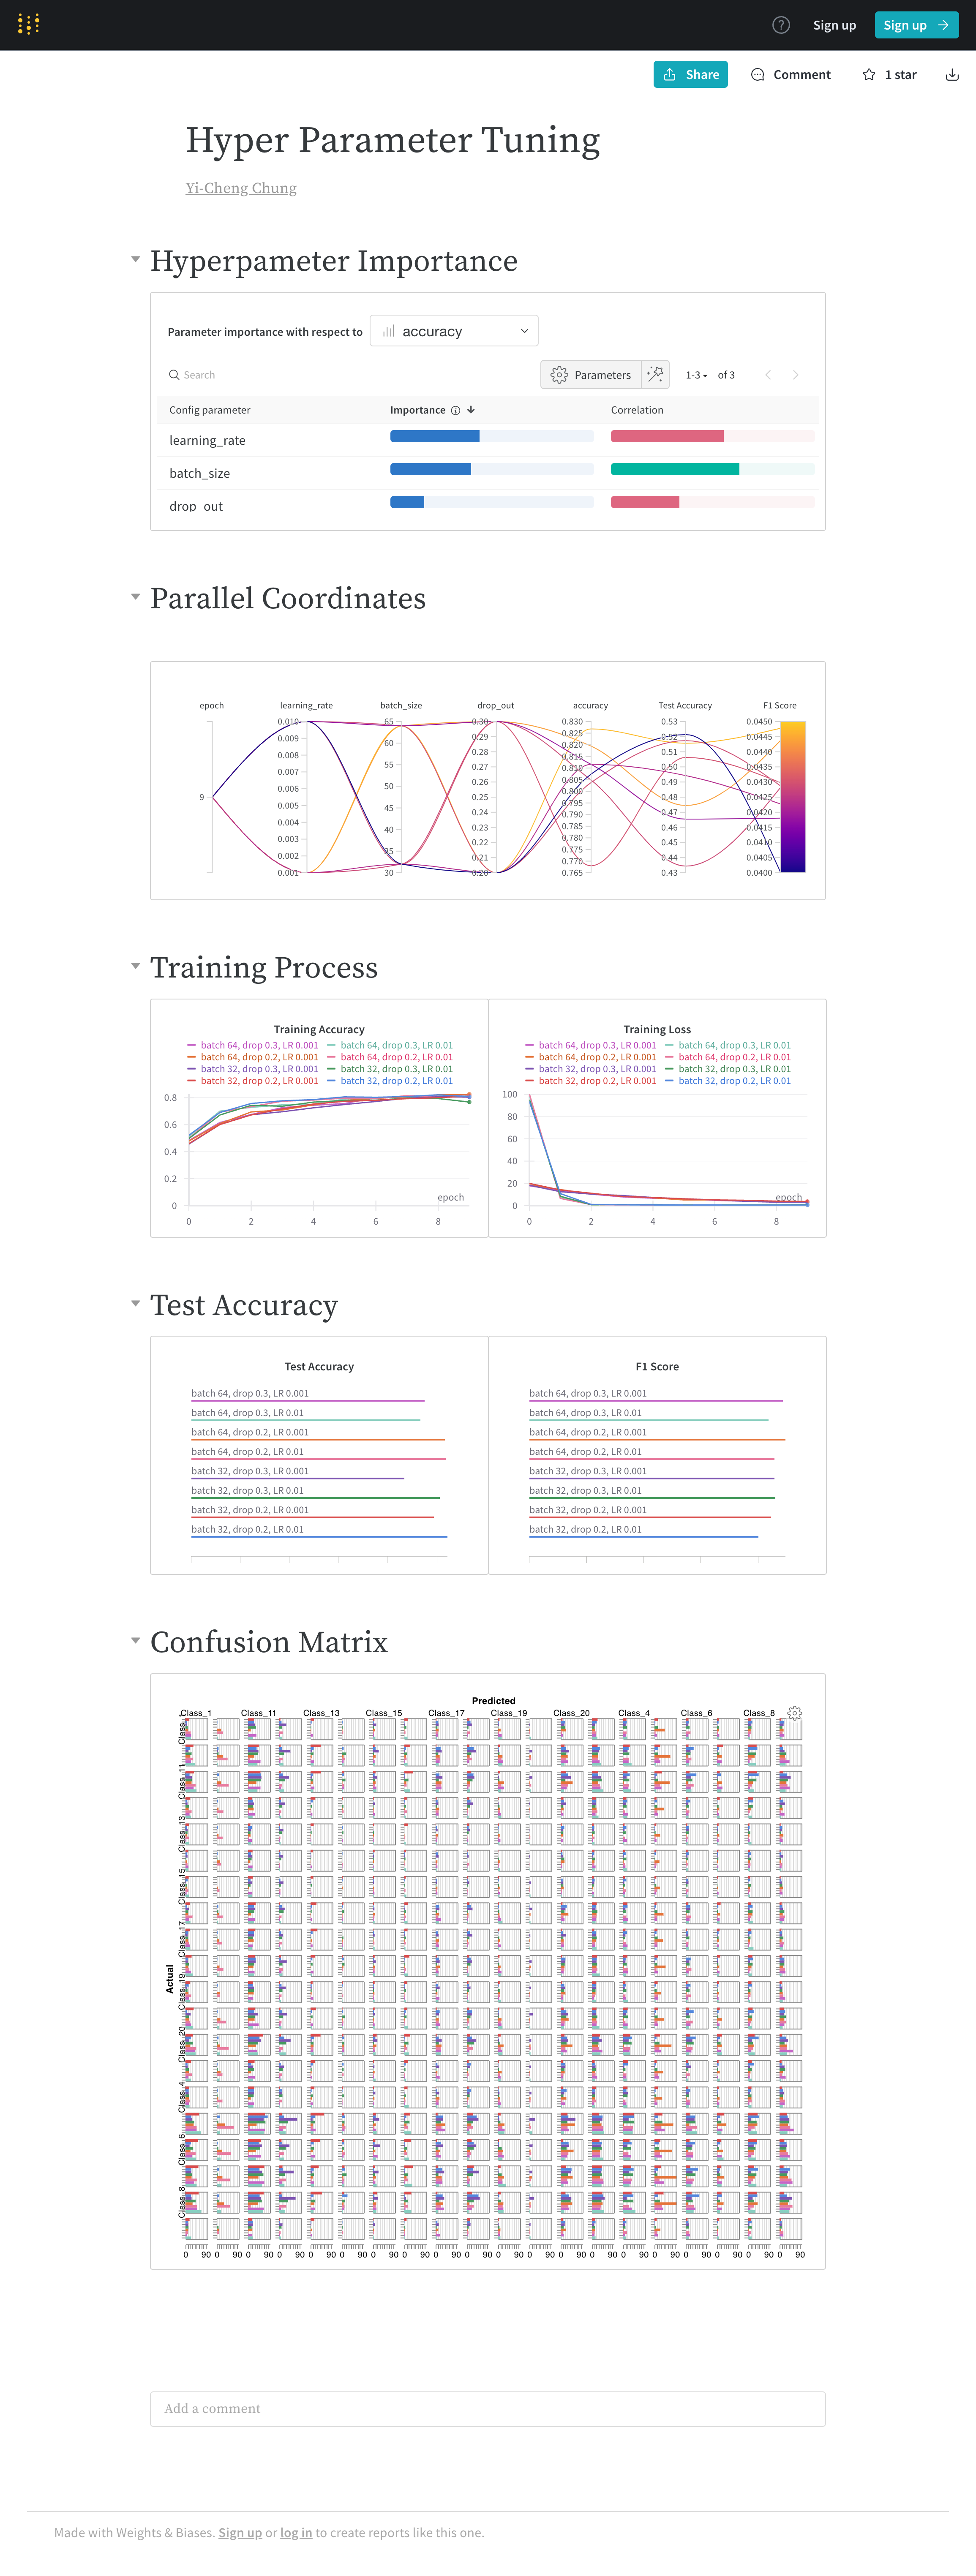 WandB link: https://api.wandb.ai/links/alyssachen/aho3ga84

## **6. Transfer learning (VGG16)**

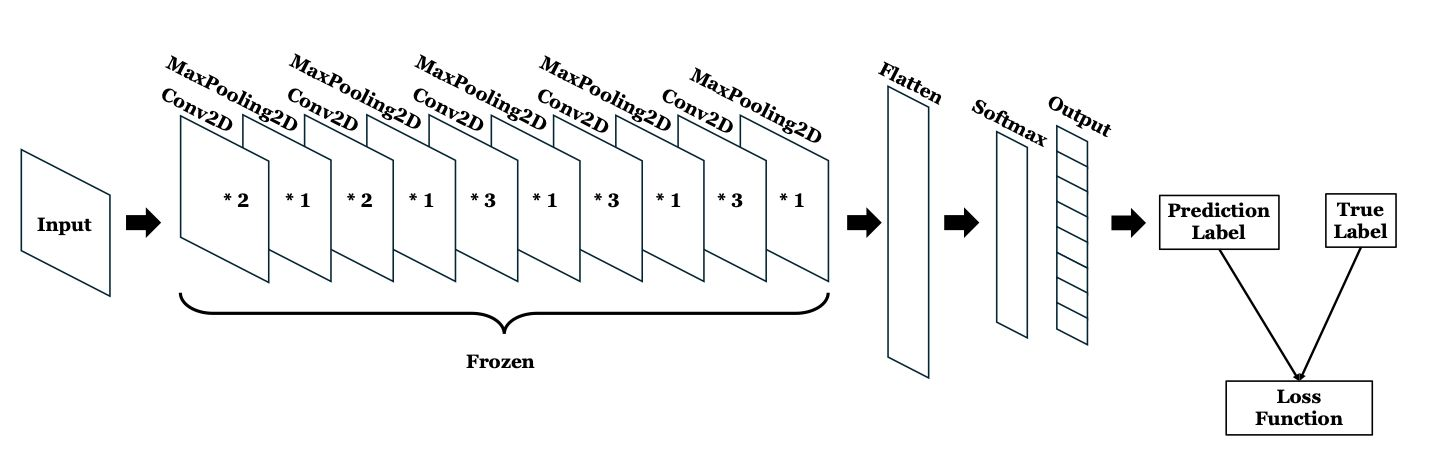

In [ ]:
from tensorflow.keras.applications import VGG16
from sklearn.metrics import f1_score, confusion_matrix

# Use VGG16 as our pre-trained model
pre_trained = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pre_trained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Freeze the layer
for layer in pre_trained.layers:
    layer.trainable = False

# Create the model
model = Sequential([
    pre_trained,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
start_time = time.time()
model.fit(train_generator, steps_per_epoch=train_generator.samples // train_generator.batch_size, epochs=10)
end_time = time.time()
duration = end_time - start_time
print(f"Training the model took {duration:.2f} seconds.")

# Evaluate the model
start_time = time.time()
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss}")

# Calculate performance metrics
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
f1 = f1_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: {cm}")

end_time = time.time()
duration = end_time - start_time
print(f"Evaluating the model took {duration:.2f} seconds.")

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
147/147 [==============================] - 137s 422ms/step - loss: 2.0368 - accuracy: 0.3348
Epoch 2/10
147/147 [==============================] - 60s 405ms/step - loss: 0.9264 - accuracy: 0.5895
Epoch 3/10
147/147 [==============================] - 59s 401ms/step - loss: 0.7231 - accuracy: 0.6409
Epoch 4/10
147/147 [==============================] - 59s 404ms/step - loss: 0.6509 - accuracy: 0.6707
Epoch 5/10
147/147 [==============================] - 60s 405ms/step - loss: 0.5995 - accuracy: 0.7069
Epoch 6/10
147/147 [==============================] - 59s 401ms/step - loss: 0.5609 - accuracy: 0.7244
Epoch 7/10
147/147 [==============================] - 60s 409ms/step - loss: 0.5181 - accuracy: 0.7540
Epoch 8/10
147/147 [==============================] - 60s 404ms/step - loss: 0.5012 - accuracy: 0.7577
Epoch 9/10
147/147 [==============================] - 60s 408ms/step - loss: 0.4631 - accuracy: 0.7841
Epoch 1

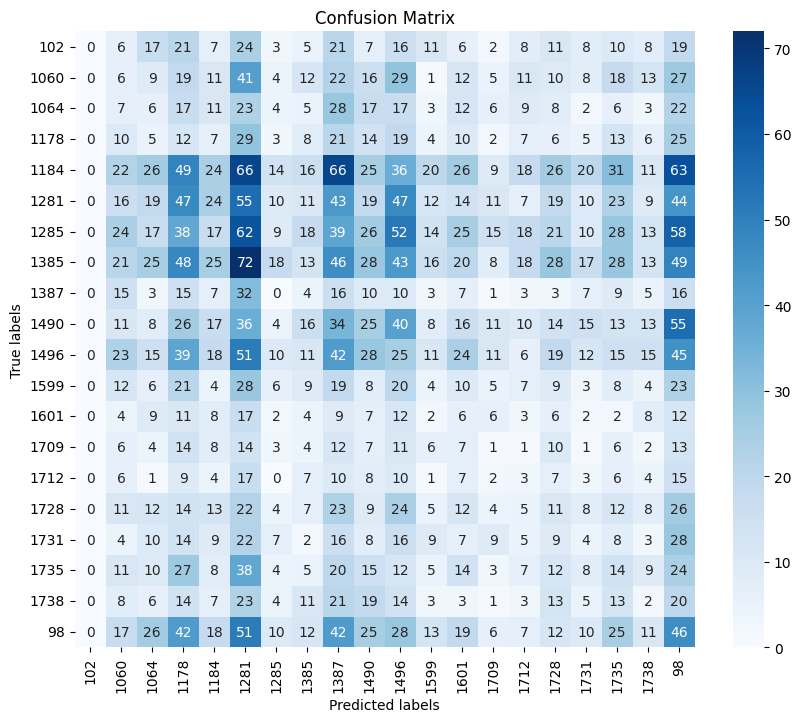

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## **7. Challenge and Resolutions**

One significant challenge we encountered was the complexity of the original testing data, which included videos featuring multiple simultaneous movements. These sequences posed difficulties in accurately identifying start and end points of individual gestures. Following advice from our professor, we strategically narrowed our focus to videos that showcased single movements, simplifying the analysis and improving data manageability.
Moreover, our initial attempt into the analysis with image segmentation every 0.5 seconds yielded a modest 3% accuracy. This low performance underscored the need for adjustments in our approach. Despite implementing data augmentation techniques and hyperparameter tuning, the initial enhancements were not sufficient to achieve the desired accuracy levels. In response, we adopted a more targeted strategy by halving the movement sample size to reduce computational demands and improve processing efficiency. We also refined our frame segmentation to 0.05 seconds, enabling a more detailed analysis of the gesture data. These changes were crucial in improving the model's training dynamics and subsequent performance.
By addressing these challenges with methodical adjustments and strategic data handling, we managed to overcome significant obstacles, setting the stage for more detailed and accurate gesture recognition in ongoing experiments. This iterative approach of refining data selection and processing parameters demonstrates our commitment to optimizing technology for effective human-computer interaction.


## **8. Conclusion**

Our project has made important progress in the field of gesture recognition with the use of neural networks. By trying different data preparation methods, various neural network models, and extensive hyperparameter tuning, we have managed to improve our model's test accuracy from 6% to an impressive 52%. This improvement underscores the potential of neural networks to interpret human gestures, which is a significant step towards enhancing human-computer interaction.
Yet, we must consider the possibility that our model may be biased towards certain visual elements in the data, rather than the gestures themselves. This possibility calls attention to the importance of ongoing scrutiny in the training processes of machine learning models to ensure they learn to recognize what they are supposed to.
Future work should explore incorporating video-based inputs into our models. The richness of video data, capturing the full sequence of human motion, could provide a more comprehensive understanding of gestures over time. This approach could potentially increase the accuracy and reliability of gesture recognition systems.
It is our hope that subsequent research will continue to build on our findings, using video data to capture the fluidity and complexity of human gestures. Such advancements could lead to significant improvements in natural and intuitive human-computer interactions, paving the way for more responsive and adaptable technology.

## **9. Use of AI tools and References**

Use of AI tools:

Using ChatGpt to refine the wording parts and to debug code.

References:
1.   https://keras.io/api/layers/activation_layers/elu/
2.   https://keras.io/api/layers/activation_layers/leaky_relu/
3.   https://www.kaggle.com/code/kasana/image-classification-using-keras-cnn
4.   https://huggingface.co/timm/vgg16.tv_in1k
5.   https://keras.io/api/applications/vgg/
6.   https://docs.clarifai.com/tutorials/how-to-evaluate-an-image-classification-model/










